# 13-14.프로젝트 : CIFAR-10 이미지 생성하기

GAN을 학습하는 과정은 보기보다 까다롭습니다. 모델 구조, learning_rate, 파라미터 초기화, 생성자와 판별자의 경쟁 관계, 데이터의 특성 등 고려해야 할 것이 참 많습니다.

이번에는 앞에서 배운 FASHION-MNIST 데이터 생성용 DCGAN 모델구조를 이용해서 CIFAR-10 데이터를 생성하는 모델을 직접 만들어 봅시다.
모델 구현 및 학습의 전과정의 흐름은 거의 비슷하겠지만, 아래와 같이 몇 가지 달라지는 점이 있습니다.

이미지 데이터의 shape가 (28, 28, 1)에서 (32, 32, 3)으로 변경됩니다. 생성자, 판별자 모델의 입출력 shape 및 모델 구조에 영향이 있습니다.
이미지가 단색의 grayscale에서 RGB 3채널의 컬러이미지로 변경됩니다. 시각화 과정에서 고려할 점이 있습니다.
입력데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라집니다.

## STEP 0. 작업환경 구성하기
<hr>

다음과 같이 작업환경을 구성합시다.

```
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history
```

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)


tensorflow 2.4.1


## STEP 1. 데이터셋 구성하기
<hr>

CIFAR-10 데이터셋도 tf.keras 안에 있는 datasets에 포함되어 있어서, 아래와 같이 손쉽게 데이터셋을 구성할 수 있습니다.

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

* 학습에 사용할 train_x의 이미지를 -1, 1로 정규화합니다.
* 로드한 학습 데이터를 시각화를 통해 확인해 봅시다.
* tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.

In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


#### 학습에 사용할 train_x의 이미지를 -1, 1로 정규화합니다.

In [4]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.


print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


#### 로드한 학습 데이터를 시각화를 통해 확인해 봅시다.

In [5]:
train_x.shape

(50000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

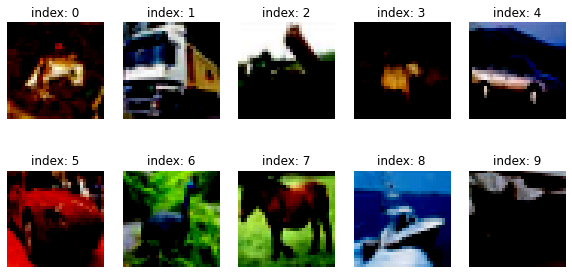

In [6]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i], 'gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.

In [81]:
# BUFFER_SIZE = 50000
# BATCH_SIZE = 256

BUFFER_SIZE = 80000
BATCH_SIZE = 256

In [82]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## STEP 2. 생성자 모델 구현하기
<hr>

* (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.
* noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.
* 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.

#### (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.


In [91]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(4*4*(64*8), use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 64*8)))

#     model.add(layers.Conv2DTranspose(64*4, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64*2, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model


In [92]:
generator = make_generator_model()

generator.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 8192)              819200    
_________________________________________________________________
batch_normalization_24 (Batc (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_67 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_24 (Conv2DT (None, 8, 8, 128)         1638400   
_________________________________________________________________
batch_normalization_25 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_68 (LeakyReLU)   (None, 8, 8, 128)       

#### noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.


In [93]:
noise = tf.random.normal([1, 100])

#### 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.

In [94]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 1])

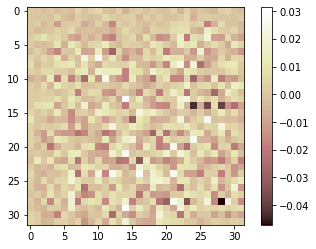

In [95]:
plt.imshow(generated_image[0, :, :, 0], cmap='pink')
plt.colorbar()
plt.show()

## STEP 3. 판별자 모델 구현하기
<hr>

* (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.
* 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.

In [102]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [103]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_76 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_77 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 4, 4, 256)       

In [104]:
decision = discriminator(generated_image, training=False)
decision

ValueError: Input 0 of layer sequential_26 is incompatible with the layer: expected axis -1 of input shape to have value 3 but received input with shape (1, 32, 32, 1)

## STEP 4. 손실함수와 최적화 함수 구현하기
<hr>

* 생성자와 판별자의 손실함수(loss)를 구현해 봅시다.
* 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.
* 생성자와 판별자를 최적화하는 optimizer를 정의합니다.

#### 생성자와 판별자의 손실함수(loss)를 구현해 봅시다.

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
vector = [[1, 2, 3],
          [4, 5, 6]]

tf.ones_like(vector)

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

In [ ]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

#### 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.

In [ ]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

#### 생성자와 판별자를 최적화하는 optimizer를 정의합니다.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## STEP 5. 훈련과정 상세 기능 구현하기
* 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.
* 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.
* 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는  draw_train_history() 함수를 구현해 봅시다.
* training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

## STEP 6. 학습 과정 진행하기
<hr>

* 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.
* 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.
* 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다.

(참고) 학습 과정 중 학습 epoch를 추가 진행해야 하거나, 학습한 모델을 활용하여 이미지를 생성할 필요가 생깁니다. 그럴 때마다 모델 학습을 처음부터 다시 진행한다면 시간 낭비가 될 것입니다.
우리는 위에서 checkpoint 모듈을 이용해 모델을 저장해 둔 바 있습니다. 이를 이용해 학습해 둔 모델을 로드하면 모델 재학습이 필요 없이 이런 작업을 진행할 수 있습니다.
아래는 checkpoint 모듈을 활용하여 모델을 로드하는 예시입니다.

In [ ]:
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

checkpoint를 통해 모델이 로드되었으면 아래 코드를 실행할 경우 로드된 모델의 파라미터 상태에서 훈련을 재개할 수도 있습니다.

%%time
train(train_dataset, EPOCHS, save_every)

## STEP 7. (optional) GAN 훈련 과정 개선하기
<hr>

* STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 봅시다.
* 모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출합니다.

(참고) 아래 언급된 페이지들에서 개선을 위한 아이디어를 얻을 수 있을 것입니다.

* How to Train a GAN? Tips and tricks to make GANs work
* 10 Lessons I Learned Training GANs for one Year
* Tips for Training Stable Generative Adversarial Networks
* Improved Techniques for Training GANs(paper)

## 회고


### 1. 이번 프로젝트에서 어려웠던 점

> 개념의 생소함.,.

### 2. 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

> 알아낸 점 : 생성 모델링, 판별모델링 이라는 것들이 있다는 것..

> 모호한 점 : input에 대한 output 사이즈 조절하는 법 등..


### 3. 루브릭 평가 지표를 맞추기 위해 시도한 것들.

> ....... ; 

### 4. 만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정.

> LMS에 대한 내용이 낯설고, 이해가 쉽지 않았음


### 5. 자기 다짐

> 버릴 건 버리자..